In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
dfenergy = pd.read_csv("../data/energy_dataset.csv")

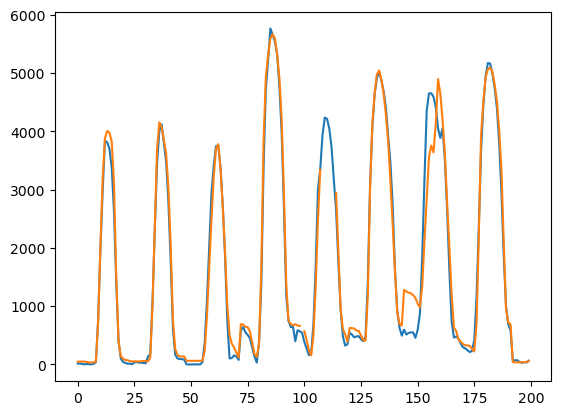

In [3]:
plt.plot(dfenergy['forecast solar day ahead'][:200])
plt.plot(dfenergy['generation solar'][:200])

In [4]:
dfenergy.head()
dfenergy['time'] = pd.to_datetime(dfenergy['time'], utc=True, infer_datetime_format=True)

/var/folders/h4/dn_r4zyd2tz_3rffhss_88hh0000gn/T/ipykernel_30056/145362555.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfenergy['time'] = pd.to_datetime(dfenergy['time'], utc=True, infer_datetime_format=True)


In [5]:
#what can we do with the forecasts. I assume the forecasts are 24 hours prior.
#can we predict better than their price day ahead? I bet we can.

dfforecast = dfenergy[['time','forecast solar day ahead', "forecast wind onshore day ahead", 'total load forecast', 'price actual']]
dfforecast.head()



,time,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,price actual
0,2014-12-31 23:00:00+00:00,17.0,6436.0,26118.0,65.41
1,2015-01-01 00:00:00+00:00,16.0,5856.0,24934.0,64.92
2,2015-01-01 01:00:00+00:00,8.0,5454.0,23515.0,64.48
3,2015-01-01 02:00:00+00:00,2.0,5151.0,22642.0,59.32
4,2015-01-01 03:00:00+00:00,9.0,4861.0,21785.0,56.04


In [6]:
#I do want to add a weekend weekday flag.
#and also try to convert time to "clock time", since I thought that's a neat idea for a NN

timex = []
timey = []
dayx = []
dayy = []
for i in range(dfforecast.shape[0]):
    day = (dfforecast['time'][i].weekday())
    dayx.append(np.cos((day / 7.0) * 2 * np.pi))
    dayy.append(np.sin((day/7.0)*2 * np.pi))
    timex.append(np.cos((dfforecast['time'][i].hour / 24.0)*2 * np.pi))
    timey.append(np.sin((dfforecast['time'][i].hour / 24.0)*2 * np.pi))

dfforecast['timex'] = timex
dfforecast['timey'] = timey
# dfforecast['weekday'] = weekdays
dfforecast['dayx'] = dayx
dfforecast['dayy'] = dayy
dfforecast['price prev'] = [0]*24 + list(dfforecast['price actual'].values[:-24])

dfforecast = dfforecast.iloc[24:,:]


/var/folders/h4/dn_r4zyd2tz_3rffhss_88hh0000gn/T/ipykernel_30056/1952760476.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfforecast['timex'] = timex
/var/folders/h4/dn_r4zyd2tz_3rffhss_88hh0000gn/T/ipykernel_30056/1952760476.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfforecast['timey'] = timey
/var/folders/h4/dn_r4zyd2tz_3rffhss_88hh0000gn/T/ipykernel_30056/1952760476.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [7]:
dfforecast = dfforecast.drop(['time'], axis = 1)

In [8]:
X = dfforecast.drop(['price actual'], axis = 1)
y = dfforecast['price actual']
y_compare = dfenergy['price day ahead']

In [9]:
#well, let's import some models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import torch
from torch import nn
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(X)
X_scaled = scaler.transform(X)

/Users/kirakalkus/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kirakalkus/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kirakalkus/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kirakalkus/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version

In [11]:
# X_train,X_test,y_train,y_test = train_test_split(X_scaled,y.values)
X_train,X_test,y_train,y_test = X_scaled[:1000 * 24],X_scaled[1000 * 24:],y.values[:1000 * 24],y.values[1000 * 24:]

In [12]:
DT = DecisionTreeRegressor(max_depth = 20)
DT.fit(X_train,y_train)


print(mean_squared_error(y_train,DT.predict(X_train)))
print(mean_squared_error(y_test,DT.predict(X_test)))
#clearly we need to regularize our model
print(DT.get_depth())


2.103058070640997
85.53707921564728
20


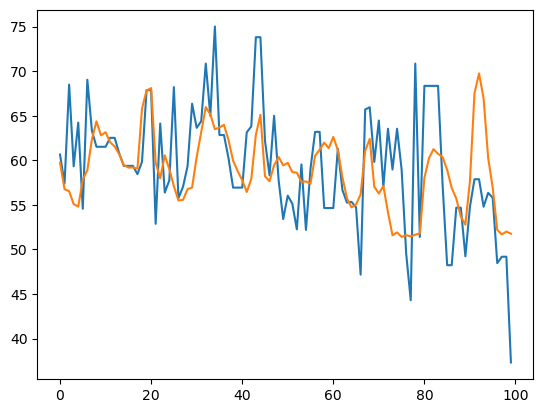

In [13]:
plt.plot(DT.predict(X_test)[:100])
plt.plot(y_test[:100])

In [14]:
RF = RandomForestRegressor()
RF.fit(X_train,y_train)

print(mean_squared_error(y_train,RF.predict(X_train)))
print(mean_squared_error(y_test,RF.predict(X_test)))

4.196445614908751
49.26009159571467


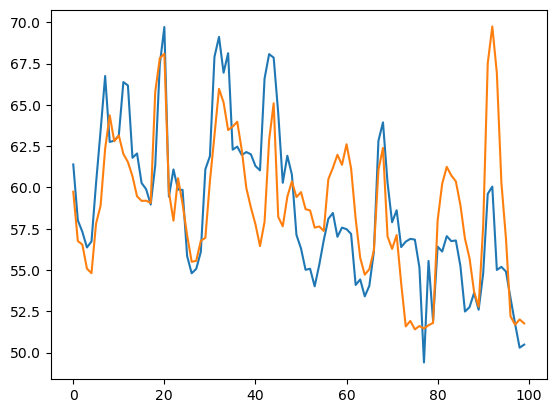

In [15]:
plt.plot(RF.predict(X_test)[:100])
plt.plot(y_test[:100])

In [16]:
#just out of curiousity, are we predicting better than the baseline?
print(mean_squared_error(RF.predict(X_scaled), y.values))
print(mean_squared_error(y_compare.values[24:],y.values))
#so yeah, we are... seems silly. perhaps they are optimizing for something else? predicting max is more important, etc.


18.394580649957195
175.51327593892694


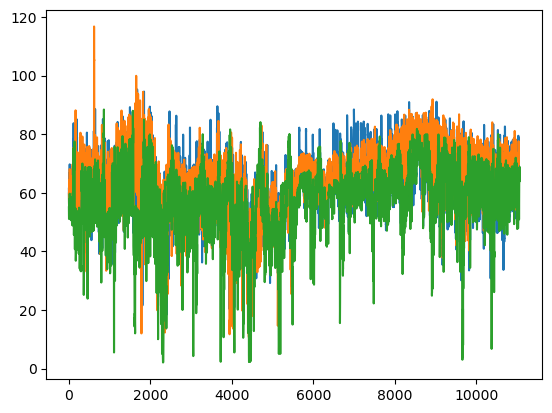

In [17]:
#okay, so how will a NN do then?

plt.plot(RF.predict(X_scaled[1000*24:]))
plt.plot(y.values[1000*24:])
plt.plot(y_compare.values[1000*24:])

In [22]:
class nnModel(nn.Module):
    
    def __init__(self,input_size = 8,n_hidden_units = 10, n_layers = 1, dropout_param = .05, activation = nn.Tanh()):
        super().__init__()
        self.layer1 = nn.Linear(input_size,n_hidden_units)
        self.middle_layers= [nn.Linear(n_hidden_units,n_hidden_units) for _ in range(n_layers)]

        self.last_layer = nn.Linear(n_hidden_units,1)

        self.dropout = nn.Dropout(dropout_param)
        self.ReLU = activation
    def forward(self,x):
        x = self.dropout(self.ReLU(self.layer1(x)))
        
        for layer in self.middle_layers:
            x = self.dropout(self.ReLU(layer(x)))
        return self.last_layer(x)
    
nn_model = nnModel(n_hidden_units = 20,n_layers = 1)

loss_fn = nn.MSELoss()

        

In [23]:
X_train_torch = torch.tensor(X_train).float()
X_test_torch = torch.tensor(X_test).float()
y_train_torch = torch.tensor(y_train).reshape(-1,1).float()
y_test_torch = torch.tensor(y_test).reshape(-1,1).float()

In [24]:

optimizer = torch.optim.Adam(params = nn_model.parameters(), lr = .01)

In [25]:
epochs = 100000

for epoch in range(epochs):
    
    nn_model.train()
    
    #forward pass
    y_pred = nn_model(X_train_torch)
    
    #compute loss
    loss = loss_fn(y_pred, y_train_torch)
    mse = mean_squared_error(y_pred.detach().numpy().flatten(),y_train_torch.detach().numpy().flatten())
    
    #Zero gradient
    optimizer.zero_grad()
    
    #backwards loss
    loss.backward()
    
    optimizer.step()
    
    if epoch % 100 == 0:
        
        y_pred_test = nn_model(X_test_torch)
        
        mse_test = mean_squared_error(y_pred_test.detach().numpy().flatten(),y_test_torch.detach().numpy().flatten())
        
        print("Epoch: " +str(epoch)+", Loss: "+str(loss.item()) + ", Test Loss: "+str(mse_test))
        
    

Epoch: 0, Loss: 3283.292724609375, Test Loss: 4233.665
Epoch: 100, Loss: 2036.80419921875, Test Loss: 2770.9639
Epoch: 200, Loss: 1150.63623046875, Test Loss: 1682.8953
Epoch: 300, Loss: 668.6671752929688, Test Loss: 1044.162
Epoch: 400, Loss: 416.6142883300781, Test Loss: 671.5971
Epoch: 500, Loss: 293.62255859375, Test Loss: 466.5916


KeyboardInterrupt: 

In [ ]:
y_tmp = nn_model(X_test_torch)
rf_tmp = RF.predict(X_test)
plt.plot(y_tmp.detach().numpy().flatten()[:120])
plt.plot(y_test[:120])
plt.plot(rf_tmp[:120])
# plt.plot(y_compare[:])

In [313]:
dfforecast["dayx"].iloc[2] = -.9009

